# `np_sin_4f4`

In [1]:
from pynq import Overlay, allocate
import numpy as np

# overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_sin_f4.bit")
# overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_sin_2f4.bit")
# overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_sin_4f4.bit")
overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_sin_8f4.bit")

L = 2**13

A = allocate(shape=(L,), dtype="f4")
B = allocate(shape=(L,), dtype="f4")

A[:] = np.random.rand(L)
B[:] = np.zeros(L)

## NumPy

In [2]:
def np_sin_f4_numpy(x1, out):
    np.sin(x1, out)

B[:] = 0
np_sin_f4_numpy(A, B)
print(B)

[0.70785785 0.11268552 0.4769256  ... 0.38561714 0.42933264 0.63132733]


## PYNQ

In [3]:
def np_sin_f4_pynq(x1, out):
#     overlay.np_sin_f4_hw_0.mmio.write(0x0, 0x01)
#     overlay.np_sin_2f4_hw_0.mmio.write(0x0, 0x01)
#     overlay.np_sin_4f4_hw_0.mmio.write(0x0, 0x01)
    overlay.np_sin_8f4_hw_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.recvchannel.transfer(out)
    overlay.axi_dma_1.recvchannel.wait()

B[:] = 0
np_sin_f4_pynq(A, B)
print(B)

[0.70785785 0.11268552 0.47692558 ... 0.3856171  0.4293326  0.6313273 ]


## pybind11

In [4]:
%%pybind11 np_sin_f4

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define IP_ADDR 0x43C00000 
#define ip_start() IP_VADDR[0x00 >> 2] = 0x00000001

void np_sin_f4(unsigned int x1_addr,
               unsigned int out_addr,
               unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
    );
    
    ip_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(S2MM_DA, out_addr);
    dma_1_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_1_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [5]:
import np_sin_f4 as calc

def np_sin_f4_pybind11(x1, out):
    calc.np_sin_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_sin_f4_pybind11(A, B)
print(B)

[0.70785785 0.11268552 0.47692558 ... 0.3856171  0.4293326  0.6313273 ]


## CFFI

In [6]:
%%writefile build_np_sin_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    r"""
    void np_sin_f4(unsigned int x1_addr,
                   unsigned int out_addr,
                   unsigned int stream_len);
    """
)

ffibuilder.set_source("np_sin_f4_cffi",
    r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define IP_ADDR 0x43C00000 
    #define ip_start() IP_VADDR[0x00 >> 2] = 0x00000001

    void np_sin_f4(unsigned int x1_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * IP_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, IP_ADDR
        );

        ip_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(S2MM_DA, out_addr);
        dma_1_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_1_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
    """
)

if __name__ == "__main__":
    import sys
    print(sys.executable)
    ffibuilder.compile(verbose=True)

Overwriting build_np_sin_f4_cffi.py


In [7]:
%%bash

/home/xilinx/perf_env/bin/python build_np_sin_f4_cffi.py

/home/xilinx/perf_env/bin/python
generating ./np_sin_f4_cffi.c
(already up-to-date)
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_sin_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_sin_f4_cffi.c -o ./np_sin_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_sin_f4_cffi.o -o ./np_sin_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In [8]:
from np_sin_f4_cffi import lib as calc

def np_sin_f4_cffi(x1, out):
    calc.np_sin_f4(x1.physical_address, out.physical_address, x1.size)

B[:] = 0
np_sin_f4_cffi(A, B)
print(B)

[0.70785785 0.11268552 0.47692558 ... 0.3856171  0.4293326  0.6313273 ]


## Timing analysis

kernel = 0, n = 4, t = 4.93877e-05
kernel = 1, n = 4, t = 0.093603566
kernel = 2, n = 4, t = 0.0003788468
kernel = 3, n = 4, t = 0.0001139277
kernel = 0, n = 8, t = 4.7387400000000006e-05
kernel = 1, n = 8, t = 0.09919343190000002
kernel = 2, n = 8, t = 0.00036288190000000005
kernel = 3, n = 8, t = 0.000276628
kernel = 0, n = 16, t = 4.95945e-05
kernel = 1, n = 16, t = 0.09335702490000002
kernel = 2, n = 16, t = 0.0001261234
kernel = 3, n = 16, t = 0.00018379670000000004
kernel = 0, n = 32, t = 6.54296e-05
kernel = 1, n = 32, t = 0.0935257857
kernel = 2, n = 32, t = 0.0001350585
kernel = 3, n = 32, t = 0.00018641110000000002
kernel = 0, n = 64, t = 6.55569e-05
kernel = 1, n = 64, t = 0.0932999463
kernel = 2, n = 64, t = 0.0003835763
kernel = 3, n = 64, t = 0.0001162419
kernel = 0, n = 128, t = 8.695380000000001e-05
kernel = 1, n = 128, t = 0.09332530630000001
kernel = 2, n = 128, t = 0.00038553290000000004
kernel = 3, n = 128, t = 0.0001186892
kernel = 0, n = 256, t = 0.0001265729
kern

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy             ┃ pynq               ┃ pybind11          ┃ cffi               ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 4       │ 4.93877e-05       │ 0.093603566        │ 0.0003788468      │ 0.0001139277       │
│ 8       │ 4.73874000000000… │ 0.099193431900000… │ 0.00036288190000… │ 0.000276628        │
│ 16      │ 4.95945e-05       │ 0.093357024900000… │ 0.0001261234      │ 0.000183796700000… │
│ 32      │ 6.54296e-05       │ 0.0935257857       │ 0.0001350585      │ 0.000186411100000… │
│ 64      │ 6.55569e-05       │ 0.0932999463       │ 0.0003835763      │ 0.0001162419       │
│ 128     │ 8.69538000000000… │ 0.093325306300000… │ 0.00038553290000… │ 0.0001186892       │
│ 256     │ 0.0001265729      │ 0.093448825700000… │ 0.0003875071      │ 0.0001225809       │
│ 512     │ 0.0002112031      │ 0.0932979506       │ 0.00040175780000… │ 0.0001255483       │
│ 1024    │ 0.0003750981      │ 0.093137665400000… │ 0.0001402991      │ 0.000197684600000… │
│ 2048    │ 0.00070423690000… │ 0.0933878011       │ 0.00014704800000… │ 0.0002121633       │
│ 4096    │ 0.0015832973      │ 0.093374546        │ 0.0004197071      │ 0.000144736000000… │
│ 8192    │ 0.0031029         │ 0.104513000500000… │ 0.0001789853      │ 0.000230675700000… │
│ 16384   │ 0.00615601690000… │ 0.0937615765       │ 0.0002226718      │ 0.000348149900000… │
│ 32768   │ 0.01225353200000… │ 0.094094305400000… │ 0.00084403200000… │ 0.000433008400000… │
│ 65536   │ 0.0245237584      │ 0.0937788672       │ 0.00071310280000… │ 0.0005900766       │
│ 131072  │ 0.04885753720000… │ 0.094125098900000… │ 0.00103584890000… │ 0.0008906896       │
│ 262144  │ 0.09747319680000… │ 0.094295609400000… │ 0.00164177810000… │ 0.0015366295       │
│ 524288  │ 0.1947683034      │ 0.0951347561       │ 0.0027724698      │ 0.0027542873       │
│ 1048576 │ 0.3957855034      │ 0.0948408547       │ 0.00540867700000… │ 0.005382909200000… │
│ 2097152 │ 0.7786498951      │ 0.1111242355       │ 0.0106519625      │ 0.010774153800000… │
└─────────┴───────────────────┴────────────────────┴───────────────────┴────────────────────┘

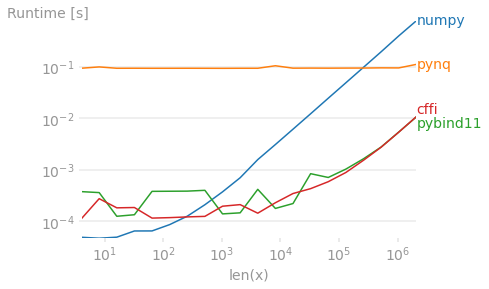

In [9]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="f4")
    B = allocate(shape=(n,), dtype="f4")

    A[:] = np.random.rand(n)
    B[:] = np.zeros(n)
    
    return A, B

kernels = [
    np_sin_f4_numpy,
    np_sin_f4_pynq,
    np_sin_f4_pybind11,
    np_sin_f4_cffi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
p = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(p)

p.show()